In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [19]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [20]:
len(dataset)

48

In [21]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[2 2 0 2 1 0 1 2 0 2 1 1 1 1 0 1 0 0 1 0 2 0 2 2 0 1 0 2 0 1 2 1]


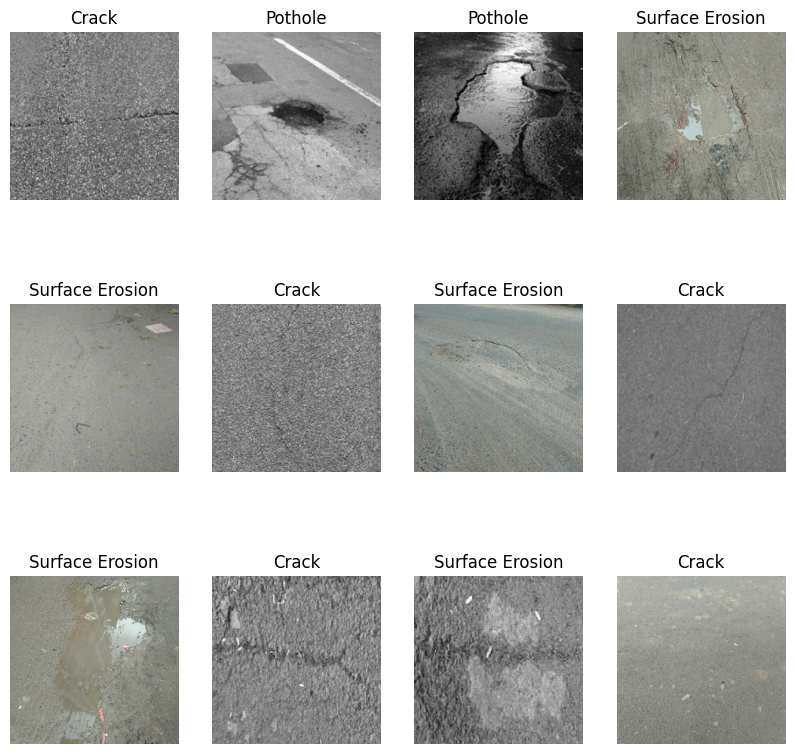

In [22]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [23]:
total_size = len(dataset)

In [ ]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 38
Validation data size: 4
Test data size: 6


In [ ]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

In [28]:


def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model


In [29]:
model = build_mobilenet_model()

In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6378 - loss: 1.1080 - val_accuracy: 0.8361 - val_loss: 0.4125
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8107 - loss: 0.4935 - val_accuracy: 0.8525 - val_loss: 0.4037
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8481 - loss: 0.4066 - val_accuracy: 0.9016 - val_loss: 0.3227
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8505 - loss: 0.3801 - val_accuracy: 0.8852 - val_loss: 0.3072
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8787 - loss: 0.3279 - val_accuracy: 0.9098 - val_loss: 0.2708
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8963 - loss: 0.2783 - val_accuracy: 0.9180 - val_loss: 0.2381
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8919 - loss: 0.2766 - val_accuracy: 0.9098 - val_loss: 0.2565
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8782 - loss: 0.2951 - val_accuracy: 0.9180 - val_loss:

In [49]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9557 - loss: 0.1447


[0.18042850494384766, 0.9479166865348816]

In [56]:
model.save("Trained Modelv2/MOBILENET.h5")
model.save("Trained Modelv2/MOBILENET.keras")

In [36]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
history.history['accuracy']

[0.7347107529640198,
 0.808264434337616,
 0.8347107172012329,
 0.8545454740524292,
 0.871074378490448,
 0.8859503865242004,
 0.8909090757369995,
 0.8884297609329224,
 0.8917355537414551,
 0.9057851433753967,
 0.9082644581794739,
 0.9099173545837402,
 0.9231404662132263,
 0.9148760437965393,
 0.9363636374473572,
 0.93388432264328,
 0.9272727370262146,
 0.9322314262390137,
 0.9297520518302917,
 0.9355372190475464,
 0.9487603306770325,
 0.9413223266601562,
 0.9347107410430908,
 0.9396694302558899,
 0.942148745059967,
 0.9429752230644226,
 0.937190055847168,
 0.9504132270812988,
 0.944628119468689,
 0.9413223266601562,
 0.9413223266601562,
 0.9487603306770325,
 0.9355372190475464,
 0.9487603306770325,
 0.9479339122772217,
 0.9561983346939087,
 0.9495867490768433,
 0.9454545378684998,
 0.9611570239067078,
 0.9570248126983643,
 0.9462810158729553,
 0.960330605506897,
 0.9504132270812988,
 0.9479339122772217,
 0.960330605506897,
 0.9586777091026306,
 0.9520661234855652,
 0.9561983346939087,
 

In [39]:
y_true = []
y_pred = []
for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
F1 Score (macro): 0.9473788454975379
F1 Score (weighted): 0.9479631356345376

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.97      0.95      0.96        65
        Pothole       0.94      0.94      0.94        48
Surface Erosion       0.94      0.95      0.94        79

       accuracy                           0.95       192
      macro avg       0.95      0.95      0.95       192
   weighted avg       0.95      0.95      0.95       192



In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

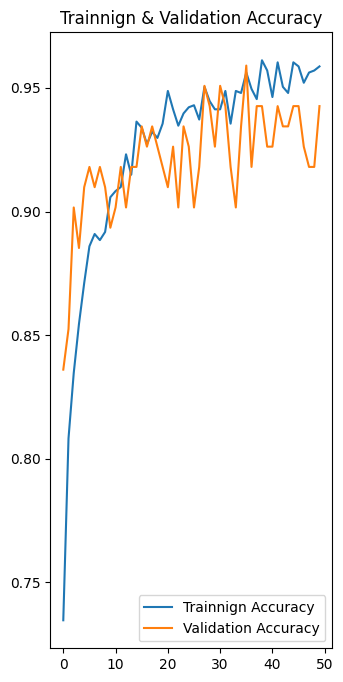

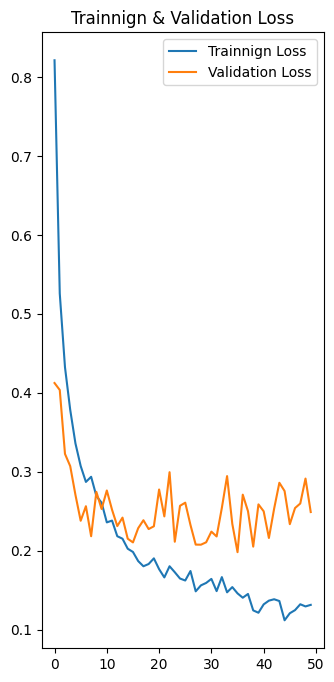

In [ ]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")
plt.show()
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [42]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9336 - loss: 0.2410


[0.18042850494384766, 0.9479166865348816]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label:  Pothole


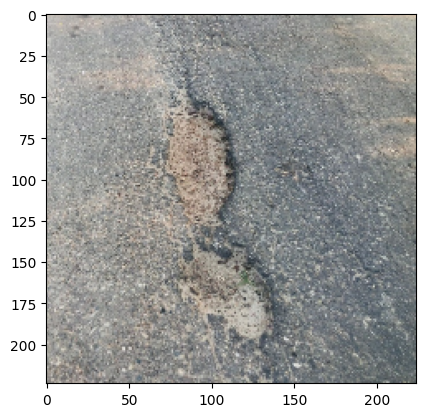

In [ ]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()
    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->71.13999938964844 Light:-> Normal lighting
Confidence:->99.98999786376953 Light:-> Normal lighting
Confidence:->95.0999984741211 Light:-> Normal lighting
Confidence:->99.55999755859375 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->99.93000030517578 Light:-> Normal lighting
Confidence:->99.8499984741211 Light:-> Normal lighting
Confidence:->95.83000183105469 Light:-> Low light
Confidence:->99.95999908447266 Light:-> Normal lighting


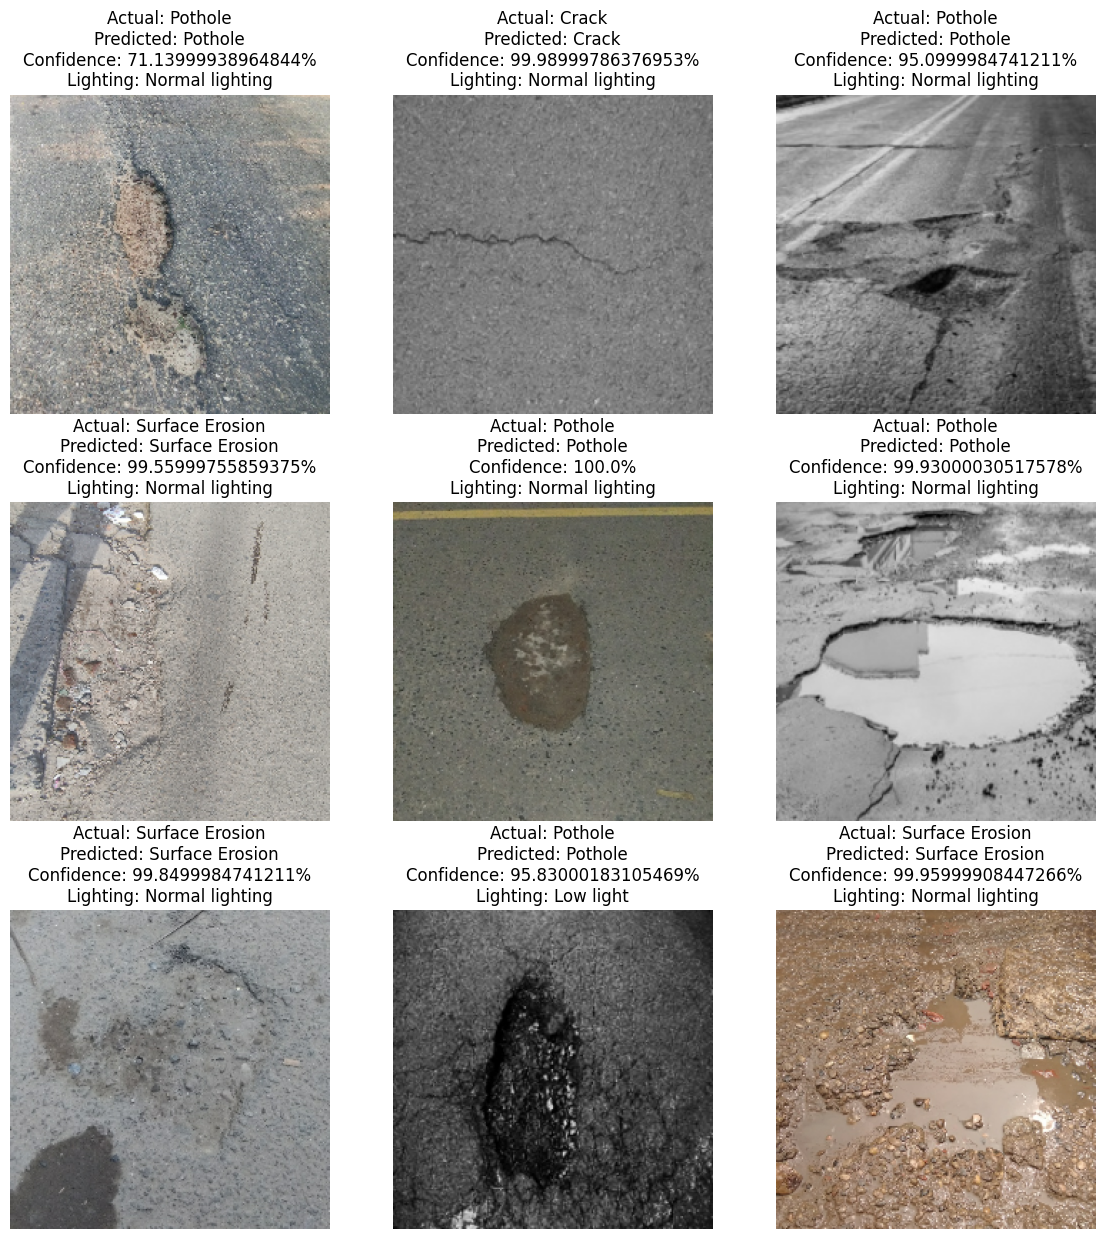

In [ ]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [46]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")

Prediction: Surface Erosion, Confidence: 99.95999908447266


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


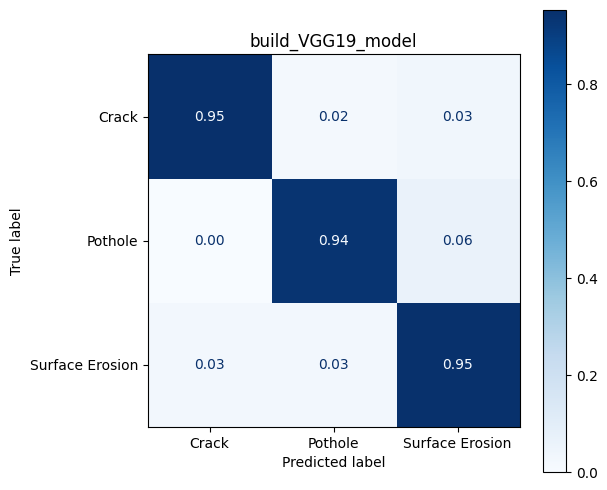

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("build_VGG19_model")
plt.savefig("Confusion Matrx/MOBILENET/mobilenet.png", dpi=300, bbox_inches='tight')
plt.show()
